В этом проекте попробуем предсказать цены акций газпрома.
Данные представляют собой результаты торгов акциями от 01.01.2020 до  14.06.2022. Данные были взяты с сайта Investing.com.

В датасете иммется результаты торгов в определенный день. Open - цена с которой рынок открылся сегодня. Closed - цена с которой рынок закрылся сегодня.
High, Low - наибольшая и нименьшая цена акции в определенный день. Volume- общий объем торгов сегодня. Currency - валюта в которой велся расчет. 

In [112]:
import investpy

In [113]:

df = investpy.get_stock_historical_data(stock='GAZP', country='Russia', from_date='01/01/1991', to_date='14/06/2022')

In [114]:
df

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2006-01-24,221.00,224.68,219.66,224.00,8983192,RUB
2006-01-25,225.50,231.00,225.00,228.38,15480374,RUB
2006-01-26,228.20,229.41,223.51,224.47,7588759,RUB
2006-01-27,225.75,231.50,224.00,228.75,12729718,RUB
2006-01-30,231.04,231.07,215.00,216.00,17251930,RUB
...,...,...,...,...,...,...
2022-06-07,297.42,298.69,294.52,297.99,15684380,RUB
2022-06-08,298.80,309.60,298.16,308.00,40392440,RUB
2022-06-09,310.00,310.52,303.20,306.50,26451350,RUB


In [115]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

Построим красивый график фондового рынка

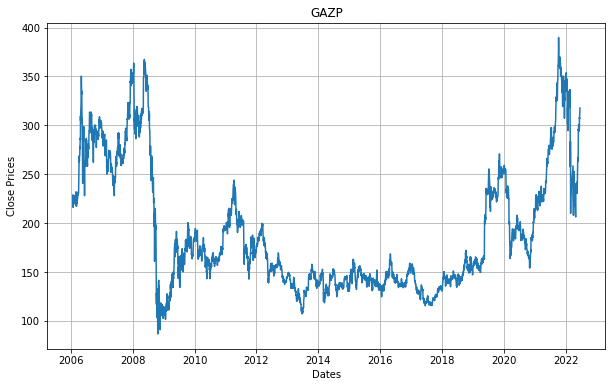

In [116]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('GAZP')
plt.show()

In [117]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=df.index, y=df['Close'], mode='lines'))
fig.show()

In [118]:
df['diff'] = df['Close'] - df['Open']
df.loc[df['diff'] >= 0, 'color'] = 'green'
df.loc[df['diff'] < 0, 'color'] = 'red'

In [119]:
import plotly

fig_stock = plotly.subplots.make_subplots(specs=[[{"secondary_y": True}]])
fig_stock.add_trace(go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close']))
fig_stock.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume'), secondary_y=True)
fig_stock.add_trace(go.Scatter(x=df.index,y=df['Close'].rolling(window=20).mean(), marker_color='blue', name='20 Day MA')) # рвзмеры торгов
fig_stock.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume', marker={'color': df['color']}), secondary_y=True) # Сделаем для каждого торга зеленый цвет если закрылся с 
                                                                                                                        # большой ценой чем открылся, красный наоборот

fig_stock.update_yaxes(range=[0,700000000],secondary_y=True)
fig_stock.update_yaxes(visible=False, secondary_y=True)
fig_stock.update_layout(xaxis_rangeslider_visible=False)
fig_stock.update_layout(title={'text':'GAZP', 'x':0.5})
fig_stock.show()


Здесь снизу, можно посмотреть объем торгов, а сверху график торгов с изображением разницы между ценой на открытии и закрытии фондового рынка.

In [120]:
df

,Open,High,Low,Close,Volume,Currency,diff,color
Date,,,,,,,,
2006-01-24,221.00,224.68,219.66,224.00,8983192,RUB,3.00,green
2006-01-25,225.50,231.00,225.00,228.38,15480374,RUB,2.88,green
2006-01-26,228.20,229.41,223.51,224.47,7588759,RUB,-3.73,red
2006-01-27,225.75,231.50,224.00,228.75,12729718,RUB,3.00,green
2006-01-30,231.04,231.07,215.00,216.00,17251930,RUB,-15.04,red
...,...,...,...,...,...,...,...,...
2022-06-07,297.42,298.69,294.52,297.99,15684380,RUB,0.57,green
2022-06-08,298.80,309.60,298.16,308.00,40392440,RUB,9.20,green
2022-06-09,310.00,310.52,303.20,306.50,26451350,RUB,-3.50,red


Произведем тест Дики-Фуллера на стационарность данных

Нуль гипотеза: Временной ряд имеет единичный корень.

Альтернативная гипотеза: Временной ряд не имеет единичного корня.

In [121]:
import  statsmodels.tsa.stattools as st

def test_stationarity(timeseries):
    print(timeseries)
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling ')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = st.adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)




In [122]:
df = df.drop(['Currency', 'color'], axis=1)

In [123]:
df = df.drop(['diff'], axis=1)

In [124]:
df_close = df['Close']

Date
2006-01-24    224.00
2006-01-25    228.38
2006-01-26    224.47
2006-01-27    228.75
2006-01-30    216.00
               ...  
2022-06-07    297.99
2022-06-08    308.00
2022-06-09    306.50
2022-06-10    309.20
2022-06-14    317.69
Name: Close, Length: 4089, dtype: float64


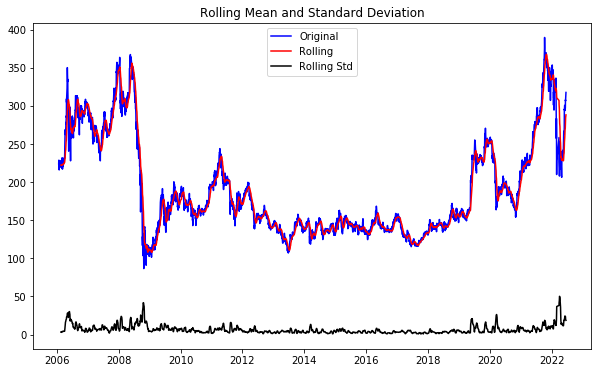

Results of dickey fuller test
Test Statistics                  -2.125582
p-value                           0.234353
No. of lags used                 29.000000
Number of observations used    4059.000000
critical value (1%)              -3.431962
critical value (5%)              -2.862252
critical value (10%)             -2.567149
dtype: float64


In [125]:
test_stationarity(df_close)

данные не стационарны т.к. Test Statistics > critical values

Пробуем сделать стационарными.

<Figure size 720x432 with 0 Axes>

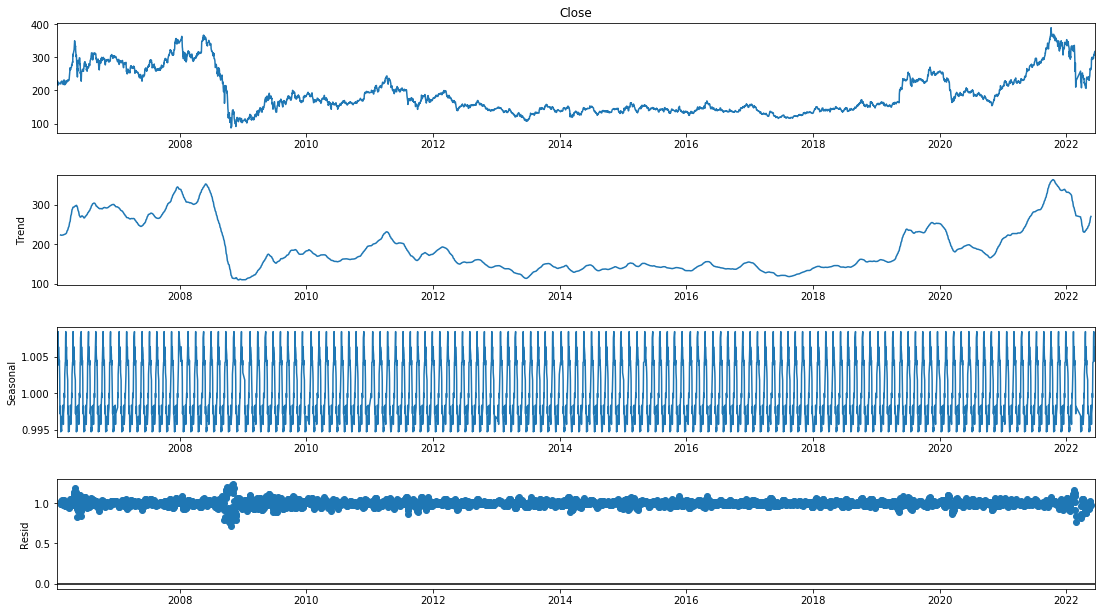

In [126]:
from  statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Разделили Тренд и Сезонность. Результирующие данные стали стционарными. Теперь возьмем логарифм от временного ряда и найдем скользящую среднюю. 

No handles with labels found to put in legend.


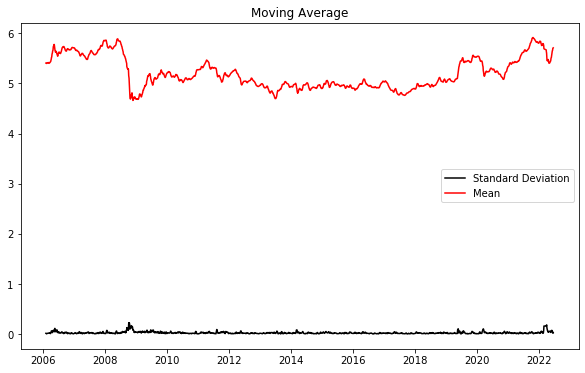

In [127]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Создадим ARIMA для того чтобы сделать данные стационарными и для предсказания цены акций. Также используем колонку Closed. То есть тренируемся на цене акций когда фондовые рынки закрылись.

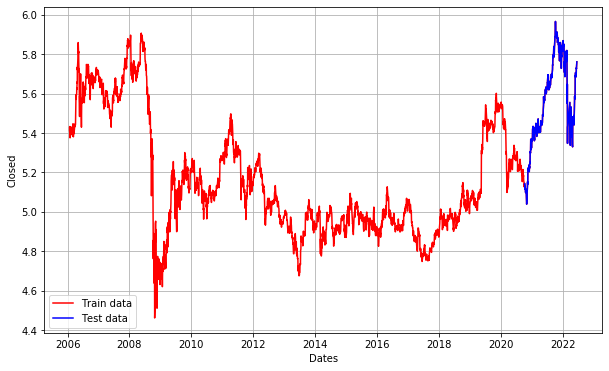

In [128]:
train_df, test_df = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closed')
plt.plot(df_log, 'red', label='Train data')
plt.plot(test_df, 'blue', label='Test data')
plt.legend()

используем AutoARIMA для нахождения подходящих параметров  p,q, d

In [129]:
aARIMA = auto_arima(train_df, start_p=0, start_q=0, test='adf', max_p=10, max_q=10, m=1, d=None, seasonal=False, start_P=0, D=0,  trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(aARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17393.623, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17392.511, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17392.527, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17395.576, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17389.925, Time=0.89 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.863 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3677
Model:               SARIMAX(0, 1, 0)   Log Likelihood                8698.788
Date:                Thu, 16 Jun 2022   AIC                         -17395.576
Time:                        05:07:00   BIC                         -17389.366
Sample:                             0   HQIC                        -17393.365
                               - 3677                             

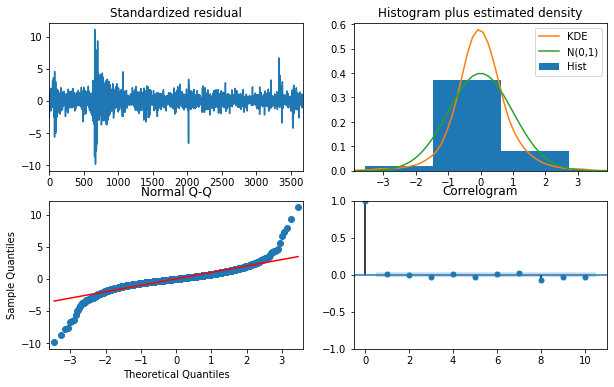

In [99]:
aARIMA.plot_diagnostics()
plt.show()

Ошибки колеблются около нуля и имеют равномерную дисперсию.

Плотность распределения - нормальное распределение со средним значением 0 и дисперсией 1.

Отклонение от красной линии имеется, значит данные искажены.

Нет автокорелляции.

In [150]:
from statsmodels.tsa.arima.model import ARIMA 

model = ARIMA(train_df, order=(0, 1, 0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3677
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8698.788
Date:                Thu, 16 Jun 2022   AIC                         -17395.576
Time:                        05:13:56   BIC                         -17389.366
Sample:                             0   HQIC                        -17393.365
                               - 3677                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   3.83e-06    134.429      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):             47734.60
Prob(Q):                              0.35   Pr

In [151]:
fitted

Предскажем цену акций с 95% доверительным интервалом.

In [166]:
fc = fitted.forecast(409, alpha=0.05)
conf = fitted.conf_int(alpha=0.05)

In [171]:
# report performance
mse = mean_squared_error(test_df, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_df, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_df, fc))
print('RMSE: '+str(rmse))

MSE: 0.23598732343821055
MAE: 0.43362032127468253
RMSE: 0.48578526473968986


Вывод

В проекте, взяли данные фондового рынка, построили график. Также выяснили, что выбранные данные не являются стационарными с помощью теста Дики-Фуллера. Сделали данные стаыионарными с помощью разделения Сезонности и Тренда.  Подобрали параметры и предсказали с помощью ARIMA модели цену акций на последнюю половину 2020-2022 г. Этот период выдался достаточно непредсказуемым. Возможно пожтому тренд сильно отличается от данных на тесте. 